## Generating Summaries
## Justyn Lewis and Emery Jacobowitz

---

Reading is hard. It would be really nice if we could just plug texts into a computer program, which could succinctly explain what's going on. This is the summarization problem. How do we figure out what information a text is trying to convey, and what to report in our summary.

There are two approaches to summarization.

The first is **extractive** summarization, where we come up with some way of ranking how important sentences are, then cutting out everything except those sentences. This is pretty easy to do, and it retains the original linguistic structure, but it's not how humans summarize things.

The "natural" approach is **abstractive** summarization. This is where we read through a text, and come up with a novel summary that captures the main ideas. This is the approach we will be implementing today.

We start by importing a dataset. This is a set of Amazon reviews for various projects over the span of a few years. Each one comes with a sample summary, which we will use to train our model.

In [1]:
import pandas as pd
import tensorflow as tf
import os

# Getting the data
# This is a dataset of 500k Amazon reviews
# We only use 100k of these.
data = pd.read_csv('data' + os.sep + 'Reviews.csv', nrows=1000)
data.drop_duplicates(subset=['Text'],inplace=True)  #dropping duplicates
data.dropna(axis=0,inplace=True)   #dropping na
text_data = data['Text']


In [2]:
print(tf.__version__)
print(tf.keras.__version__)

print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices('GPU'))

2.10.0
2.10.0
False
[]


## Prologue: Preparing the data

The first step when dealing with raw text is to clean it up, so we will use NLTK's NLP utilities to do this. This step includes:
- Case normalization
- Lemmatizing
    - i.e. replacing inflected words with their "dictionary forms"
- Removing punctuation
- etc.

To accomplish this, we will use a **tokenizer** from Keras. The goal is to train the tokenizer on our dataset, to create a "vocabulary" which accurately represents the kind of things we are going to summarize. The tokenizer also cleans the data, as above.

Before the tokenizer runs, we first need to append all of the summaries with tags representing their starting and ending points.

In [3]:
summary_data = data['Summary']
summary_data = ['_START_ ' + summary + ' _END_' for summary in summary_data]

summary_data[:3]

['_START_ Good Quality Dog Food _END_',
 '_START_ Not as Advertised _END_',
 '_START_ "Delight" says it all _END_']

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer

# AKA out-of-vocabulary token
# For unknown words that aren't relevant to tokenization
oov = '_oov_'

# initialize the tokenizer
text_tokenizer = Tokenizer(oov_token=oov)

# fit it on our dataset
text_tokenizer.fit_on_texts(text_data)

# split the text up into sequences
input_seqs = text_tokenizer.texts_to_sequences(text_data)

# repeat for the summaries
summary_tokenizer = Tokenizer(oov_token=oov)
summary_tokenizer.fit_on_texts(summary_data)
target_seqs = text_tokenizer.texts_to_sequences(summary_data)

In [5]:
print('Input vocabulary size: ', len(text_tokenizer.word_index))
print('Target vocabulary size: ', len(summary_tokenizer.word_index))
text_tokenizer.texts_to_sequences(['We', 'love', 'Artificial', 'Intelligence', '!'])
# The output is a measure of how frequent these terms are in our dataset.
# Notice that "!" is removed, because the tokenizer strips out punctuation.




Input vocabulary size:  6093
Target vocabulary size:  1186


[[43], [47], [659], [1], []]

The last bit of preprocessing is to pad and truncate our sequences, since we are going to want to always feed in inputs of the same length to our model. This is why we needed to label the starts and ends of the summaries. The maximum length after preprocessing will just be the average item length plus a buffer for now. 

In [6]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from math import floor
import numpy

input_max_len = floor(numpy.average([len(item) for item in text_data])) + 25
target_max_len = floor(numpy.average([len(item) for item in summary_data])) + 25

print("Input maxlen:  ", input_max_len)
print("Target maxlen: ", target_max_len)

# the 'post' options mean we pad/truncate at the end of the sequence, not before it.
input_seqs = pad_sequences(input_seqs, maxlen=input_max_len, padding='post', truncating='post')
target_seqs = pad_sequences(target_seqs, maxlen=target_max_len, padding='post', truncating='post')

Input maxlen:   419
Target maxlen:  62


A final adjustment is to set the buffer and batch sizes for our model, producing a randomized Tensorflow Dataset.

In [7]:
BUFFER = 20000
BATCH_SIZE = 32

input_seqs = tf.cast(input_seqs, dtype=tf.int32)
target_seqs = tf.cast(target_seqs, dtype=tf.int32)

dataset = tf.data.Dataset.from_tensor_slices((input_seqs, target_seqs)).shuffle(BUFFER).batch(BATCH_SIZE)
dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 419), dtype=tf.int32, name=None), TensorSpec(shape=(None, 62), dtype=tf.int32, name=None))>

In [8]:
[(batch, (inp, tar)) for (batch, (inp, tar)) in enumerate(dataset)]

[(0,
  (<tf.Tensor: shape=(32, 419), dtype=int32, numpy=
   array([[ 31,  38,  17, ...,   0,   0,   0],
          [304,  25, 559, ...,   0,   0,   0],
          [454, 313, 202, ...,   0,   0,   0],
          ...,
          [  3, 141,   2, ...,   0,   0,   0],
          [ 39,   7,  15, ...,   0,   0,   0],
          [ 20,  18,  11, ...,   0,   0,   0]])>,
   <tf.Tensor: shape=(32, 62), dtype=int32, numpy=
   array([[1008,  148,    4, ...,    0,    0,    0],
          [1008,  559,  304, ...,    0,    0,    0],
          [1008,  436,  582, ...,    0,    0,    0],
          ...,
          [1008,  253,   34, ...,    0,    0,    0],
          [1008,  226,   46, ...,    0,    0,    0],
          [1008,   47,   11, ...,    0,    0,    0]])>)),
 (1,
  (<tf.Tensor: shape=(32, 419), dtype=int32, numpy=
   array([[  94,  694,    6, ...,    0,    0,    0],
          [   3,   18,  487, ...,    0,    0,    0],
          [  15,  308,  371, ...,    0,    0,    0],
          ...,
          [  17,   23, 

## The Transformer Architecture, pt. I
---
### Data Utilities
The thing about self-attention in transformers is we could end up losing ordinal information about our data. To solve this problem, we use "positional encodings", where we embed ordinal information within our word data. We want to implement these formulae:
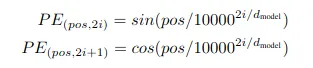

In [9]:
# Math is hard.
# This section is closely adapted from https://medium.com/swlh/abstractive-text-summarization-using-transformers-3e774cc42453

# calculate PE
def positional_encoding(pos, d_model):
    angle_rads = get_angles(
        numpy.arange(pos)[:, numpy.newaxis],
        numpy.arange(d_model)[numpy.newaxis, :],
        d_model
    )

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = numpy.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = numpy.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[numpy.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

# generate the internal argument to the trig function
def get_angles(position, i, d_model):
    angle_rates = 1 / numpy.power(10000, (2 * (i // 2)) / numpy.float32(d_model))
    return position * angle_rates

Next, we need two small masks.

One is the padding mask, which ignores the padded portions of our sequences.

The other is the lookahead mask, which ignores words that come after a given word. This is important because we want to make predictions based on the words we have seen already, since language is linear.

In [72]:
def padding_mask(seq):
    # we padded with 0s
    remove_padding = tf.math.equal(seq, 0)
    new_seq = tf.cast(remove_padding, tf.float32)
    # add two new axes
    return new_seq[:, tf.newaxis, tf.newaxis, :]

# Once again, I don't really understand how this mask works. It's from the same source above.
def lookahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

print(target_seqs[:0])
print(padding_mask(target_seqs[:0]))
print(padding_mask(input_seqs[:4]))
print(padding_mask(input_seqs[:5]))
print('==================================================')
print(lookahead_mask(5))
print(lookahead_mask(4))
print(lookahead_mask(3))
print(lookahead_mask(2))

tf.Tensor([], shape=(0, 62), dtype=int32)
tf.Tensor([], shape=(0, 1, 1, 62), dtype=float32)
tf.Tensor(
[[[[0. 0. 0. ... 1. 1. 1.]]]


 [[[0. 0. 0. ... 1. 1. 1.]]]


 [[[0. 0. 0. ... 1. 1. 1.]]]


 [[[0. 0. 0. ... 1. 1. 1.]]]], shape=(4, 1, 1, 419), dtype=float32)
tf.Tensor(
[[[[0. 0. 0. ... 1. 1. 1.]]]


 [[[0. 0. 0. ... 1. 1. 1.]]]


 [[[0. 0. 0. ... 1. 1. 1.]]]


 [[[0. 0. 0. ... 1. 1. 1.]]]


 [[[0. 0. 0. ... 1. 1. 1.]]]], shape=(5, 1, 1, 419), dtype=float32)
tf.Tensor(
[[0. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1.]
 [0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0.]], shape=(5, 5), dtype=float32)
tf.Tensor(
[[0. 1. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 0.]], shape=(4, 4), dtype=float32)
tf.Tensor(
[[0. 1. 1.]
 [0. 0. 1.]
 [0. 0. 0.]], shape=(3, 3), dtype=float32)
tf.Tensor(
[[0. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)


## The Transformer Architecture, pt. 2
---
### Paying Self-Attention

At this point, we can start assembling the transformer. The first step is to implement a scaled dot product function, which is the key to our self-attention layer. This includes a few components: 
- *Matrix multiplication* (i.e. dot product) of our query and our key
- *Scaling*
    - We need to scale down our inputs in order to prevent them from being too large, so we divide by $\sqrt{d_k}$, a scaling factor proportional to the size of our input.
- An optional *mask*
    - This is where we will use our padding mask from before
- *Softmax*
    - Transforming the value to fit in a \[0, 1\] probability distribution.
- Another step of matrix multiplication of the result of the above with our value.

Thus, the scaled dot product attention is equivalent to 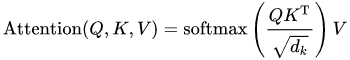 although the affect of the mask is not counted here.


In [91]:
# takes in a query, a key, a value, and an optional mask.
# returns a tuple of (the output, the attention weights)
def sdp_attention(q, k, v, mask=None):
    # Step 1: QK^T, AKA matrix multiplication
    qk = tf.matmul(q, k, transpose_b=True)
    
    #Scaling
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled = qk / tf.math.sqrt(dk)
    
    # apply the mask, only if it is not the default None option.
    if mask is not None:
        print('scaled: ', scaled)
        print('mask:   ', mask)
        scaled += (mask * -1e9)
    
    # softmax
    softmax = tf.nn.softmax(scaled, axis=-1)
    
    # finally, multiply by v
    result = tf.matmul(softmax, v)
    return result, softmax

Next, we need to actually make this into a layer in our Transformer architecture. We do this by implementing a subclass of the Layer class from Keras. The important method that we implement is call(), which applies the logic of the layer. Keras documentation also suggests implementing a few other methods, but we don't think those are necessary for our project, so we are going to tactically ignore them.

We make it "multi-headed", which means that we can split up the calculations to make them more efficient. If we want to split into *h* heads, then the sizes of the query, key, and value (AKA the *depth*) will be equal to *d_model* / *h*. Therefore, the former must be evenly divisible by the latter.

In [89]:
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, heads):
        super(AttentionLayer, self).__init__()
        self.d_model = d_model
        self.heads = heads
        
        # d_model needs to be divisible by the number of heads
        if not d_model % heads == 0:
            raise RuntimeError('d_model (' + str(d_model) + ') must be divisible by heads (' + str(heads) + ').')
        
        self.depth = d_model // heads
        
        # make Keras densely-connected NN layers for the data we eventually have
        self.q_layer = tf.keras.layers.Dense(d_model)
        self.k_layer = tf.keras.layers.Dense(d_model)
        self.v_layer = tf.keras.layers.Dense(d_model)
        
        # dense layer that will eventually store the output
        self.out_layer = tf.keras.layers.Dense(d_model)
    
    def call(self, q, v, k, mask):       
        # start applying all those layers we made
        Q = self.q_layer(q)
        V = self.q_layer(v)
        K = self.q_layer(k)
        
        # split the heads apart, so that we are multi-headed
        split_Q = self.split(Q, BATCH_SIZE)
        split_V = self.split(V, BATCH_SIZE)
        split_K = self.split(K, BATCH_SIZE)
    
        # apply the attention
        print("HIIII")
        attention = sdp_attention(split_Q, split_K, split_V, mask)
        weights = attention[1]
        attention_results = tf.transpose(attention[0], perm=[0,2,1,3])
        
        # concatenate attention back to one vector
        attention_results = tf.reshape(attention_results, (tf.shape(q)[0], -1, self.d_model))
        output = self.out_layer(attention_results)
        
        return output, weights
        
    
    # helper method for splitting the heads
    def split(self, layer, batch):
        Layer = tf.reshape(layer, (batch, -1, self.heads, self.depth))
        Layer = tf.transpose(Layer, perm=[0,2,1,3])
        return Layer
        
AttentionLayer(6, 3)

### Feeding it Forward

The last basic unit of a transformer that we have to implement is a Feed-Forward Network (FFN) layer. This is pretty simple, since we just need to sequentially go from one layer to another, and Keras has this functionality.

In [76]:
def ffn(d_model, d_ffn):
    l1 = tf.keras.layers.Dense(d_ffn)
    l2 = tf.keras.layers.Dense(d_model)
    return tf.keras.Sequential([l1, l2])

## The Transformer Architecture, pt. 3
---
### Building the Transformer 

So far, we've made the individual building blocks of the Transformer, which process data at each step. Now, we can build the main components: the Encoder and the Decoder. These are comprised of individual layers, each of which contain:
- An attention layer
- A FFN layer
- A normalization layer
- A dropout layer
    - When training, randomly sets some inputs to 0, and distributes that value to the other inputs.

In [77]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, heads, d_ffn):
        super(EncoderLayer, self).__init__()
        
        # the MH Attention layer
        self.att = AttentionLayer(d_model, heads)
        
        # the FFN  layer
        self.ffn = ffn(d_model, d_ffn)
        
        # Normie layers
        # we use a smaller epsilon value than standard
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=0.000001)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=0.000001)
        
        # Dropout layers
        # We apply dropout 10% of the time.
        self.drop1 = tf.keras.layers.Dropout(0.1)
        self.drop2 = tf.keras.layers.Dropout(0.1)
        
    def call(self, datum, is_training, mask):
        # Sorry for the weird formatting.
        # I think this is the best way to present the process
        
        attention = self.att(datum, datum, datum, mask)[0]
        attention = self.drop1(attention, training=is_training)
        attention = self.norm1(datum + attention)
        
        # <...>   <---   normalize <--  dropout    <--   attention <-- input
#         attention = self.norm1( datum + self.drop1( self.att(datum, datum, datum, mask), training=is_training))
        
        #           normalize     <--       dropout <-- ffn <-- <...>
        feed = self.ffn(attention)
        feed = self.drop2(feed, training=is_training)
        feed = self.norm2(attention + feed)
        
#         feed = self.norm2( attention + self.drop2( self.ffn(attention), training=is_training))
        
        return feed

A Decoder layer is pretty much the same as an Encoder layer, except that it has that extra attention layer. 

In [78]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, heads, d_ffn):
        super(DecoderLayer, self).__init__()
        
        # the MH Attention layers
        self.att1 = AttentionLayer(d_model, heads)
        self.att2 = AttentionLayer(d_model, heads)
        
        # the FFN  layer
        self.ffn = ffn(d_model, d_ffn)
        
        # Normie layers
        # we use a smaller epsilon value than standard
        norm1 = tf.keras.layers.LayerNormalization(epsilon=0.000001)
        norm2 = tf.keras.layers.LayerNormalization(epsilon=0.000001)
        norm3 = tf.keras.layers.LayerNormalization(epsilon=0.000001)
        
        # Dropout layers
        # We apply dropout 10% of the time.
        drop1 = tf.keras.layers.Dropout(0.1)
        drop2 = tf.keras.layers.Dropout(0.1)
        drop3 = tf.keras.layers.Dropout(0.1)
        
    # The decoder actually needs to use the masks we defined earlier
    def call(self, datum, encoder_result, is_training, look_mask, pad_mask):
        
        # The first attention layer
        att1_res = self.att1(datum, datum, datum, look_mask)
        att1_out = att1_res[0]
        att1_weights = att1_res[1]
        att1_out = self.norm1(datum + (self.drop1(att1_out, training=is_training)))
        
        # This extra attention layer takes in the input from the encoder as a query
        # and combines it with the first layer's output, using. 
        att2_res = self.att2(out1, encoder_result, encoder_result, pad_mask)
        att2_out = att2_res[0]
        att2_weights = att1_res[1]
        att2_out = self.norm2(att1_out + (self.drop2(att2_out, training=is_training)))
        
        # Finally, the ffn layer
        ffn_out = self.norm3(att2_out + self.drop3(self.ffn(att2_out), training=is_training))
        
        return ffn_out, att1_weights, att2_weights
        

### Assembling the components

Now that we have our Encoder/Decoder layers, we can actually put them together to form the Encoder and Decoder themselves.

These are basically just bigger Keras Layers that have multiple smaller layers inside.

In [79]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, layers, d_model, heads, d_ffn, vocab_size, max_pos):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.layers = layers

        # creates an embedding layer with the size of the vocabulary
        self.embedding = tf.keras.layers.Embedding(vocab_size, self.d_model)
        
        self.pos_enc = positional_encoding(max_pos, self.d_model)

        self.encoder_layers = []
        for i in range(layers):
            l = EncoderLayer(d_model, heads, d_ffn)
            self.encoder_layers.append(l)

        self.drop = tf.keras.layers.Dropout(0.1)
    
    def call(self, datum, is_training, mask):
        # get the length of the input
        length = tf.shape(datum)[1]
        
        # get the input embedding
        Datum = self.embedding(datum)
        Datum = Datum * tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        
        # apply the positional encoding
        Datum += self.pos_enc[:, :length, :]
        
        # apply dropout
        Datum = self.drop(Datum, training=is_training)
        
        # apply all of the Encoder layers in order
        for layer in self.encoder_layers:
            Datum = layer(Datum, is_training, mask)
        
        return Datum

In [80]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, layers, d_model, heads, d_ffn, vocab_size, max_pos):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.layers = layers

        # creates an embedding layer with the size of the vocabulary
        self.embedding = tf.keras.layers.Embedding(vocab_size, self.d_model)
        
        self.pos_enc = positional_encoding(max_pos, self.d_model)

        self.decoder_layers = []
        for i in range(layers):
            l = DecoderLayer(d_model, heads, d_ffn)
            self.decoder_layers.append(l)

        self.drop = tf.keras.layers.Dropout(0.1)
    
    def call(self, datum, decoded_output, is_training, look_mask, pad_mask):
        # get the length of the input
        length = tf.shape(datum)[1]
        attn_weights = {}
        
        # get the input embedding
        Datum = self.embedding(datum)
        Datum = Datum * tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        
        # apply the positional encoding
        Datum += self.pos_enc[:, :length, :]
        
        # apply dropout
        Datum = self.drop(Datum, training=is_training)
        
        # apply all of the Decoder layers in order
        for index, layer in enumerate(self.decoder_layers):
            Datum, block1, block2 = layer(Datum, decoded_output, is_training, look_mask, pad_mask)
            
            # store the attention weights in a dictionary
            attn_weights['decoder_layer{}_block1'.format(index+1)] = block1
            attn_weights['decoder_layer{}_block2'.format(index+1)] = block2

        
        return Datum, attn_weights

## The Transformer Architecture, pt. 4
---
### The Transformer Itself

Finally, we have all the pieces ready to put the Transformer together. To do this, we use the Model class from Keras.

In [93]:
class Transformer(tf.keras.Model):
    def __init__(self, layers, d_model, heads, d_ffn, vocab_size_input, vocab_size_target, max_pos_input, max_pos_target):
        super(Transformer, self).__init__()
        
        # the encoder
        self.encoder = Encoder(layers, d_model, heads, d_ffn, vocab_size_input, max_pos_input)
        
        # the decoder
        self.decoder = Decoder(layers, d_model, heads, d_ffn, vocab_size_target, max_pos_target)
        
        # a final transformation layer
        self.output_layer = tf.keras.layers.Dense(vocab_size_target)
        
    def call(self, input_data, target_data, pad_mask_enc, pad_mask_dec, look_mask_dec, is_training):
        
        enc = self.encoder(input_data, is_training, pad_mask_enc)
        print("encoding complete")
        
        dec_results = self.decoder(target_data, enc, is_training, look_mask_dec, pad_mask_dec)
        print("decoding complete")
        
        result = self.output_layer(dec_results[0])
        
        return result, dec_results[1]

## Next Steps: Training and Inference
---
Now that we have assembled our transformer model, we have to train it on the dataset. First, we actually create a Transformer:

In [82]:
# these parameters can be tweaked
LAYERS  = 4
D_MODEL = 64
D_FFN   = 256
HEADS   = 8
EPOCHS  = 10

enc_size = len(text_tokenizer.word_index) + 1
dec_size = len(summary_tokenizer.word_index) + 1


t = Transformer(LAYERS, D_MODEL, HEADS, D_FFN, enc_size, dec_size, enc_size, dec_size)
t

The tutorial we followed describes a training schedule which comes from the original Transformer paper:
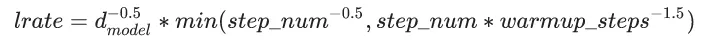

We want to implement this to make out training more efficient. To implement this, we inherit from the LearningRateSchedule class from Keras, which means that we have to implement its call() method. This method takes in *step_num*, and produces *lrate*.

In [83]:
class Schedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    # warmup = the number of warmup steps
    def __init__(self, d_model, warmup=100):
        super(Schedule, self).__init__()
        
        self.d_model = tf.cast(d_model, tf.float32)
        
        self.warmup = warmup
        
    def call(self, step_num):
        step = tf.cast(step_num, tf.float32)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(tf.math.rsqrt(step), step * (self.warmup ** -1.5))

Schedule(128).call(100)

<tf.Tensor: shape=(), dtype=float32, numpy=0.008838835>

At this point, the tutorial we were following stopped explaining training, except for some very broad statements. So, we read through their sample code, and tried to understand what was going on, step by step.

First, we use our *lrate* schedule with a Keras Adam optimizer, using parameters suggested by the Transformer paper.

In [84]:
adam_optimizer = tf.keras.optimizers.Adam(Schedule(D_MODEL), beta_1=0.9, beta_2=0.98, epsilon=1e-9)

Next, we create a SparseCategoricalCrossEntropy object. This allows us to keep track of the amount of information lost between each of our predictions, and each label.

In [85]:
entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

# create a simple mean metric to evaluate loss
loss_metric = tf.keras.metrics.Mean()

def loss(actual, predicted):
    Loss = entropy(actual, predicted)
    
    # create and apply an inversion mask
    # this is necessary because we use 0s to pad short sequences,
    # and we don't want those to just have huge loss penalties.
    mask = tf.cast(tf.math.logical_not(tf.math.equal(actual, 0), dtype=Loss.dtype))
    Loss = Loss * mask
    
    # proportionalize the result
    result = tf.reduce_sum(Loss) / tf.resuce_sum(mask)
    
    return result

Now, we'll make a helper function to create the padding and lookahead masks, since those are annoying to do manually.

In [86]:
# mask maker, mask maker, make me a mask 
# returns a tuple of the encoding pad mask, the decoding pad mask,
# and the decoding pad + lookahead mask.
def mask_maker(input_, target_):
    enc_pad_in = padding_mask(input_)
    dec_pad_in = padding_mask(input_)
    
    dec_look = lookahead_mask(tf.shape(target_)[1])
    dec_pad_targ = padding_mask(target_)
    
    # (enc_pad, dec_pad, lookahead)
    return enc_pad_in, dec_pad_in, tf.maximum(dec_look, dec_pad_targ)

This is a checkpoint manager, which saves the training states every so often.
This snippet of utility code was taken directly from the tutorial.

In [87]:
checkpoint_path = "checkpoints"

ckpt = tf.train.Checkpoint(transformer=t, optimizer=adam_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

Now, we can get onto the actual training!

In [96]:
import time

# the function annotation helps Tensorflow run this more efficiently
@tf.function
def train(input_, target_):
    target_input  = target_[:, :-1]
    target_actual = target_[:, 1:]
    
    masks = mask_maker(input_, target_)
    
    with tf.GradientTape() as tape:
        preds = t(
            input_,
            target_input,
            masks[0], # pad_mask_enc
            masks[1], # pad_mask_dec
            masks[2], # look_mask_dec
            True # is_training is true
        )
        
        Loss = loss(target_actual, preds[0])
    
    gradients = tape.gradient(Loss, t.trainable_variables)
    adam_optimizer.apply_gradients(zip(gradients, t.trainable_variables))

    loss_metric(Loss)
    
# this part is directly copied, just to try to get it to work
for epoch in range(EPOCHS):
    start = time.time()

    loss_metric.reset_states()
  
    for (batch, (inp, tar)) in enumerate(dataset):
        train(inp, tar)
    
        # 55k samples
        # we display 3 batch results -- 0th, middle and last one (approx)
        # 55k / 64 ~ 858; 858 / 2 = 429
#         if batch % 429 == 0:
#             print ('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, train_loss.result()))
      
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))
    
    print ('Epoch {} Loss {:.4f}'.format(epoch + 1, train_loss.result()))

    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))


scaled:  Tensor("transformer_4/encoder_4/encoder_layer_16/attention_layer_51/truediv:0", shape=(32, 8, 419, 419), dtype=float32)
mask:    Tensor("strided_slice_2:0", shape=(32, 1, 1, 419), dtype=float32)
scaled:  Tensor("transformer_4/encoder_4/encoder_layer_17/attention_layer_52/truediv:0", shape=(32, 8, 419, 419), dtype=float32)
mask:    Tensor("strided_slice_2:0", shape=(32, 1, 1, 419), dtype=float32)
scaled:  Tensor("transformer_4/encoder_4/encoder_layer_18/attention_layer_53/truediv:0", shape=(32, 8, 419, 419), dtype=float32)
mask:    Tensor("strided_slice_2:0", shape=(32, 1, 1, 419), dtype=float32)
scaled:  Tensor("transformer_4/encoder_4/encoder_layer_19/attention_layer_54/truediv:0", shape=(32, 8, 419, 419), dtype=float32)
mask:    Tensor("strided_slice_2:0", shape=(32, 1, 1, 419), dtype=float32)
scaled:  Tensor("transformer_4/decoder_4/decoder_layer_16/attention_layer_55/truediv:0", shape=(32, 8, 61, 61), dtype=float32)
mask:    Tensor("Maximum:0", shape=(32, 1, 62, 62), dtype

ValueError: in user code:

    File "C:\Users\emery\AppData\Local\Temp\ipykernel_13336\3524479449.py", line 12, in train  *
        preds = t(
    File "C:\Users\emery\anaconda3\envs\tensorflow\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\emery\AppData\Local\Temp\__autograph_generated_file6x4cvn8o.py", line 11, in tf__call
        dec_results = ag__.converted_call(ag__.ld(self).decoder, (ag__.ld(target_data), ag__.ld(enc), ag__.ld(is_training), ag__.ld(look_mask_dec), ag__.ld(pad_mask_dec)), None, fscope)
    File "C:\Users\emery\AppData\Local\Temp\__autograph_generated_filemrimg9u6.py", line 35, in tf__call
        ag__.for_stmt(ag__.converted_call(ag__.ld(enumerate), (ag__.ld(self).decoder_layers,), None, fscope), None, loop_body, get_state, set_state, ('Datum',), {'iterate_names': '(index, layer)'})
    File "C:\Users\emery\AppData\Local\Temp\__autograph_generated_filemrimg9u6.py", line 28, in loop_body
        (Datum, block1, block2) = ag__.converted_call(ag__.ld(layer), (ag__.ld(Datum), ag__.ld(decoded_output), ag__.ld(is_training), ag__.ld(look_mask), ag__.ld(pad_mask)), None, fscope)
    File "C:\Users\emery\AppData\Local\Temp\__autograph_generated_filen9wsstew.py", line 10, in tf__call
        att1_res = ag__.converted_call(ag__.ld(self).att1, (ag__.ld(datum), ag__.ld(datum), ag__.ld(datum), ag__.ld(look_mask)), None, fscope)
    File "C:\Users\emery\AppData\Local\Temp\__autograph_generated_filej9v05bqs.py", line 16, in tf__call
        attention = ag__.converted_call(ag__.ld(sdp_attention), (ag__.ld(split_Q), ag__.ld(split_K), ag__.ld(split_V), ag__.ld(mask)), None, fscope)
    File "C:\Users\emery\AppData\Local\Temp\__autograph_generated_filecgcjf1ai.py", line 31, in tf__sdp_attention
        ag__.if_stmt(ag__.ld(mask) is not None, if_body, else_body, get_state, set_state, ('scaled',), 1)
    File "C:\Users\emery\AppData\Local\Temp\__autograph_generated_filecgcjf1ai.py", line 26, in if_body
        scaled += mask * -1000000000.0

    ValueError: Exception encountered when calling layer "transformer_4" "                 f"(type Transformer).
    
    in user code:
    
        File "C:\Users\emery\AppData\Local\Temp\ipykernel_13336\654210736.py", line 18, in call  *
            dec_results = self.decoder(target_data, enc, is_training, look_mask_dec, pad_mask_dec)
        File "C:\Users\emery\anaconda3\envs\tensorflow\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
        File "C:\Users\emery\AppData\Local\Temp\__autograph_generated_filemrimg9u6.py", line 35, in tf__call
            ag__.for_stmt(ag__.converted_call(ag__.ld(enumerate), (ag__.ld(self).decoder_layers,), None, fscope), None, loop_body, get_state, set_state, ('Datum',), {'iterate_names': '(index, layer)'})
        File "C:\Users\emery\AppData\Local\Temp\__autograph_generated_filemrimg9u6.py", line 28, in loop_body
            (Datum, block1, block2) = ag__.converted_call(ag__.ld(layer), (ag__.ld(Datum), ag__.ld(decoded_output), ag__.ld(is_training), ag__.ld(look_mask), ag__.ld(pad_mask)), None, fscope)
        File "C:\Users\emery\AppData\Local\Temp\__autograph_generated_filen9wsstew.py", line 10, in tf__call
            att1_res = ag__.converted_call(ag__.ld(self).att1, (ag__.ld(datum), ag__.ld(datum), ag__.ld(datum), ag__.ld(look_mask)), None, fscope)
        File "C:\Users\emery\AppData\Local\Temp\__autograph_generated_filej9v05bqs.py", line 16, in tf__call
            attention = ag__.converted_call(ag__.ld(sdp_attention), (ag__.ld(split_Q), ag__.ld(split_K), ag__.ld(split_V), ag__.ld(mask)), None, fscope)
        File "C:\Users\emery\AppData\Local\Temp\__autograph_generated_filecgcjf1ai.py", line 31, in tf__sdp_attention
            ag__.if_stmt(ag__.ld(mask) is not None, if_body, else_body, get_state, set_state, ('scaled',), 1)
        File "C:\Users\emery\AppData\Local\Temp\__autograph_generated_filecgcjf1ai.py", line 26, in if_body
            scaled += mask * -1000000000.0
    
        ValueError: Exception encountered when calling layer "decoder_4" "                 f"(type Decoder).
        
        in user code:
        
            File "C:\Users\emery\AppData\Local\Temp\ipykernel_13336\2448223447.py", line 37, in call  *
                Datum, block1, block2 = layer(Datum, decoded_output, is_training, look_mask, pad_mask)
            File "C:\Users\emery\anaconda3\envs\tensorflow\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler  **
                raise e.with_traceback(filtered_tb) from None
            File "C:\Users\emery\AppData\Local\Temp\__autograph_generated_filen9wsstew.py", line 10, in tf__call
                att1_res = ag__.converted_call(ag__.ld(self).att1, (ag__.ld(datum), ag__.ld(datum), ag__.ld(datum), ag__.ld(look_mask)), None, fscope)
            File "C:\Users\emery\AppData\Local\Temp\__autograph_generated_filej9v05bqs.py", line 16, in tf__call
                attention = ag__.converted_call(ag__.ld(sdp_attention), (ag__.ld(split_Q), ag__.ld(split_K), ag__.ld(split_V), ag__.ld(mask)), None, fscope)
            File "C:\Users\emery\AppData\Local\Temp\__autograph_generated_filecgcjf1ai.py", line 31, in tf__sdp_attention
                ag__.if_stmt(ag__.ld(mask) is not None, if_body, else_body, get_state, set_state, ('scaled',), 1)
            File "C:\Users\emery\AppData\Local\Temp\__autograph_generated_filecgcjf1ai.py", line 26, in if_body
                scaled += mask * -1000000000.0
        
            ValueError: Exception encountered when calling layer "decoder_layer_16" "                 f"(type DecoderLayer).
            
            in user code:
            
                File "C:\Users\emery\AppData\Local\Temp\ipykernel_13336\3294731785.py", line 28, in call  *
                    att1_res = self.att1(datum, datum, datum, look_mask)
                File "C:\Users\emery\anaconda3\envs\tensorflow\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler  **
                    raise e.with_traceback(filtered_tb) from None
                File "C:\Users\emery\AppData\Local\Temp\__autograph_generated_filej9v05bqs.py", line 16, in tf__call
                    attention = ag__.converted_call(ag__.ld(sdp_attention), (ag__.ld(split_Q), ag__.ld(split_K), ag__.ld(split_V), ag__.ld(mask)), None, fscope)
                File "C:\Users\emery\AppData\Local\Temp\__autograph_generated_filecgcjf1ai.py", line 31, in tf__sdp_attention
                    ag__.if_stmt(ag__.ld(mask) is not None, if_body, else_body, get_state, set_state, ('scaled',), 1)
                File "C:\Users\emery\AppData\Local\Temp\__autograph_generated_filecgcjf1ai.py", line 26, in if_body
                    scaled += mask * -1000000000.0
            
                ValueError: Exception encountered when calling layer "attention_layer_55" "                 f"(type AttentionLayer).
                
                in user code:
                
                    File "C:\Users\emery\AppData\Local\Temp\ipykernel_13336\32935471.py", line 33, in call  *
                        attention = sdp_attention(split_Q, split_K, split_V, mask)
                    File "C:\Users\emery\AppData\Local\Temp\ipykernel_13336\3890593852.py", line 15, in sdp_attention  *
                        scaled += (mask * -1e9)
                
                    ValueError: Dimensions must be equal, but are 61 and 62 for '{{node transformer_4/decoder_4/decoder_layer_16/attention_layer_55/add}} = AddV2[T=DT_FLOAT](transformer_4/decoder_4/decoder_layer_16/attention_layer_55/truediv, transformer_4/decoder_4/decoder_layer_16/attention_layer_55/mul)' with input shapes: [32,8,61,61], [32,1,62,62].
                
                
                Call arguments received by layer "attention_layer_55" "                 f"(type AttentionLayer):
                  • q=tf.Tensor(shape=(32, 61, 64), dtype=float32)
                  • v=tf.Tensor(shape=(32, 61, 64), dtype=float32)
                  • k=tf.Tensor(shape=(32, 61, 64), dtype=float32)
                  • mask=tf.Tensor(shape=(32, 1, 62, 62), dtype=float32)
            
            
            Call arguments received by layer "decoder_layer_16" "                 f"(type DecoderLayer):
              • datum=tf.Tensor(shape=(32, 61, 64), dtype=float32)
              • encoder_result=tf.Tensor(shape=(32, 419, 64), dtype=float32)
              • is_training=True
              • look_mask=tf.Tensor(shape=(32, 1, 62, 62), dtype=float32)
              • pad_mask=tf.Tensor(shape=(32, 1, 1, 419), dtype=float32)
        
        
        Call arguments received by layer "decoder_4" "                 f"(type Decoder):
          • datum=tf.Tensor(shape=(32, 61), dtype=int32)
          • decoded_output=tf.Tensor(shape=(32, 419, 64), dtype=float32)
          • is_training=True
          • look_mask=tf.Tensor(shape=(32, 1, 62, 62), dtype=float32)
          • pad_mask=tf.Tensor(shape=(32, 1, 1, 419), dtype=float32)
    
    
    Call arguments received by layer "transformer_4" "                 f"(type Transformer):
      • input_data=tf.Tensor(shape=(32, 419), dtype=int32)
      • target_data=tf.Tensor(shape=(32, 61), dtype=int32)
      • pad_mask_enc=tf.Tensor(shape=(32, 1, 1, 419), dtype=float32)
      • pad_mask_dec=tf.Tensor(shape=(32, 1, 1, 419), dtype=float32)
      • look_mask_dec=tf.Tensor(shape=(32, 1, 62, 62), dtype=float32)
      • is_training=True
